Best Parameters are lr: 0.001, hidden_dim: 32 with MSE: 210.8127685546875


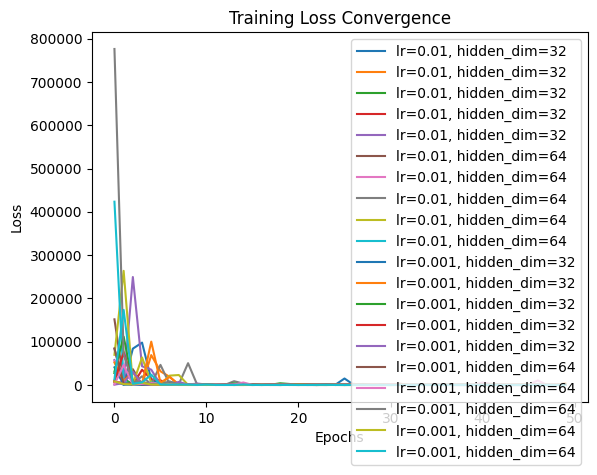

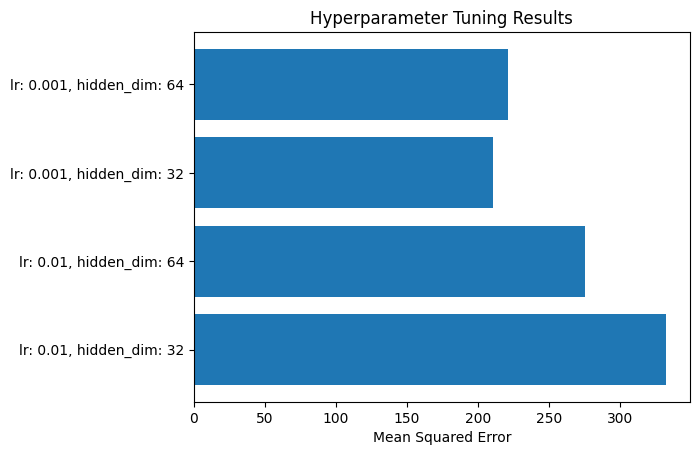

Best model saved to E:\A files\Master\Dissertation\ML\MLP\best_model.pt
Mean Squared Error for PA: 131.71


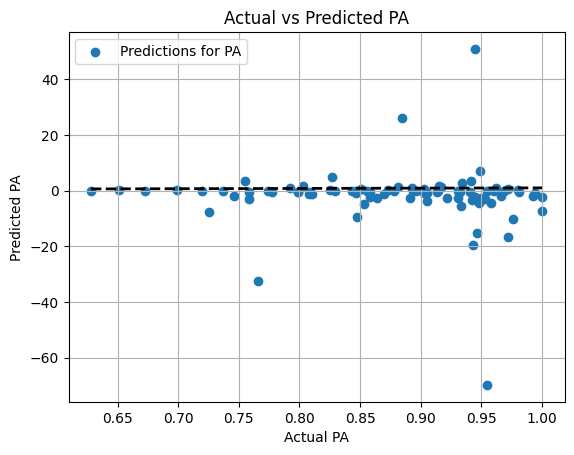

Performance plot saved to: E:\A files\Master\Dissertation\ML\MLP\Performance_PA.jpg
Mean Squared Error for IoU: 64.54


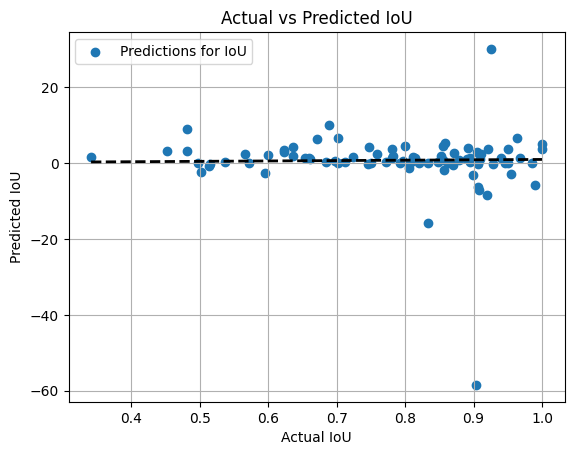

Performance plot saved to: E:\A files\Master\Dissertation\ML\MLP\Performance_IoU.jpg
Mean Squared Error for DSC: 278.89


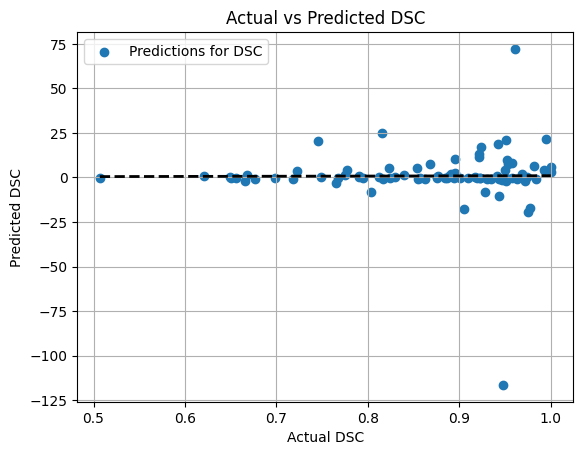

Performance plot saved to: E:\A files\Master\Dissertation\ML\MLP\Performance_DSC.jpg
Mean Squared Error for MSE: 455.48


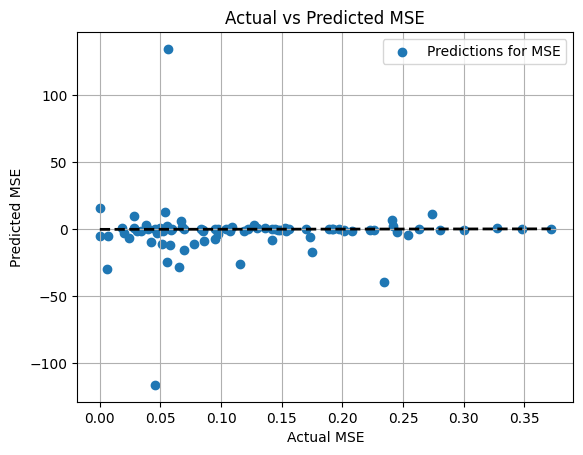

Performance plot saved to: E:\A files\Master\Dissertation\ML\MLP\Performance_MSE.jpg
Mean Squared Error for NHD: 198.47


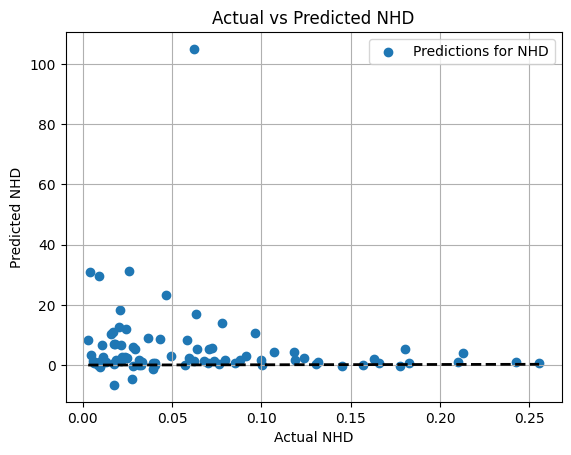

Performance plot saved to: E:\A files\Master\Dissertation\ML\MLP\Performance_NHD.jpg


In [5]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

# Set device to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Create directories for saving plots
grid_search_save_path = "E:\\A files\\Master\\Dissertation\\ML\\MLP\\grid_search_plots"
performance_save_path = "E:\\A files\\Master\\Dissertation\\ML\\MLP\\performance_plots"
os.makedirs(grid_search_save_path, exist_ok=True)
os.makedirs(performance_save_path, exist_ok=True)

# Load data
data_path = "E:\\A files\\Master\\Dissertation\\ML\\dataset.csv"
data = pd.read_csv(data_path)

# Prepare data
X = data.drop(columns=['sample', 'PA', 'IoU', 'DSC', 'MSE', 'NHD']).values
y = data[['PA', 'IoU', 'DSC', 'MSE', 'NHD']].values

# Split the data into train and test sets
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert test set to PyTorch tensors and DataLoader
X_test_tensor = torch.FloatTensor(X_test).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Hyperparameter tuning
best_mse = float('inf')
best_params = None
learning_rates = [0.01, 0.001]
hidden_dims = [32, 64]
cv = KFold(n_splits=5, shuffle=True, random_state=42)
grid_results = {}

for lr in learning_rates:
    for hidden_dim in hidden_dims:
        fold_mses = []
        for train_idx, val_idx in cv.split(X_train_full):
            X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
            y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]
            X_train_tensor = torch.FloatTensor(X_train).to(device)
            y_train_tensor = torch.FloatTensor(y_train).to(device)
            X_val_tensor = torch.FloatTensor(X_val).to(device)
            y_val_tensor = torch.FloatTensor(y_val).to(device)

            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
            train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

            model = MLP(X_train.shape[1], hidden_dim, y_train.shape[1]).to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            criterion = nn.MSELoss()

            # Training and validation
            model.train()
            epoch_losses = []
            for epoch in range(50):
                for batch_X, batch_y in train_loader:
                    optimizer.zero_grad()
                    output = model(batch_X)
                    loss = criterion(output, batch_y)
                    loss.backward()
                    optimizer.step()
                epoch_losses.append(loss.item())

            plt.plot(epoch_losses, label=f'lr={lr}, hidden_dim={hidden_dim}')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.title('Training Loss Convergence')

            # Validation
            model.eval()
            with torch.no_grad():
                val_output = model(X_val_tensor)
                mse = criterion(val_output, y_val_tensor)
                fold_mses.append(mse.item())

        avg_mse = np.mean(fold_mses)
        grid_results[(lr, hidden_dim)] = avg_mse

        if avg_mse < best_mse:
            best_mse = avg_mse
            best_params = (lr, hidden_dim)

print(f"Best Parameters are lr: {best_params[0]}, hidden_dim: {best_params[1]} with MSE: {best_mse}")

# Saving Convergence plot
convergence_plot_path = os.path.join(performance_save_path, "Convergence_Plot.jpg")
plt.legend()
plt.savefig(convergence_plot_path)
plt.show()

# Visualization of different hyperparameter effects
labels = [f"lr: {lr}, hidden_dim: {hidden}" for lr, hidden in grid_results.keys()]
plt.figure()
plt.barh(labels, grid_results.values())
plt.xlabel('Mean Squared Error')
plt.title('Hyperparameter Tuning Results')

# Save Grid Search plot
grid_search_plot_path = os.path.join(grid_search_save_path, "Grid_Search_Results.jpg")
plt.savefig(grid_search_plot_path)
plt.show()

# Train the best model on the full training set
best_model = MLP(X_train_full.shape[1], best_params[1], y_train_full.shape[1]).to(device)
optimizer = torch.optim.Adam(best_model.parameters(), lr=best_params[0])
criterion = nn.MSELoss()
best_model.train()
X_train_full_tensor = torch.FloatTensor(X_train_full).to(device)
y_train_full_tensor = torch.FloatTensor(y_train_full).to(device)
train_dataset = TensorDataset(X_train_full_tensor, y_train_full_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

for epoch in range(50):  # You can change this to desired number of epochs
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        output = best_model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

# Save the trained best model
model_save_path = "E:\\A files\\Master\\Dissertation\\ML\\MLP\\best_model.pt"
torch.save(best_model.state_dict(), model_save_path)
print(f"Best model saved to {model_save_path}")

# Evaluate the model on the test set
best_model.eval()
actuals = []
predictions = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        output = best_model(batch_X.to(device))
        actuals.append(batch_y.cpu().numpy())
        predictions.append(output.cpu().numpy())

# Convert lists to numpy arrays for easier manipulation
actuals = np.vstack(actuals)
predictions = np.vstack(predictions)

# Calculate MSE for each output variable
output_names = ['PA', 'IoU', 'DSC', 'MSE', 'NHD']
mse_per_output = {}
for i, name in enumerate(output_names):
    mse = mean_squared_error(actuals[:, i], predictions[:, i])
    mse_per_output[name] = mse
    print(f"Mean Squared Error for {name}: {mse:.2f}")
    
    plt.figure()
    plt.scatter(actuals[:, i], predictions[:, i], label=f'Predictions for {name}')
    plt.plot([actuals[:, i].min(), actuals[:, i].max()], [actuals[:, i].min(), actuals[:, i].max()], 'k--', lw=2)
    plt.xlabel(f'Actual {name}')
    plt.ylabel(f'Predicted {name}')
    plt.title(f'Actual vs Predicted {name}')
    plt.legend()
    plt.grid(True)
    
    plot_save_path = f"E:\\A files\\Master\\Dissertation\\ML\\MLP\\Performance_{name}.jpg"
    plt.savefig(plot_save_path, format='jpg')
    plt.show()
    print(f"Performance plot saved to: {plot_save_path}")